In [1]:
from mnist import MNIST
import numpy as np
import random
from matplotlib import pyplot as plt
from IPython.core.debugger import Tracer


mndata = MNIST('/home/nbuser/python-mnist/data')
all_raw_images, all_labels = mndata.load_training()

all_raw_images = np.asarray(all_raw_images)
all_labels = np.asarray(all_labels)

In [2]:
def whiten(images):
    out = (np.asarray(images)) / np.std(images)
    out = out - np.mean(out)
    return out
    
images = whiten(all_raw_images)[:50000]
labels = all_labels[:50000]

val_images = whiten(all_raw_images)[50000:]
val_labels = all_labels[50000:]

all_raw_test_images, test_labels = mndata.load_testing()
test_images = whiten(all_raw_test_images)
test_labels = np.asarray(test_labels)

Raw
33.3184214498
6172.85048229
Whitened
0.000976324968854
1.00251425221


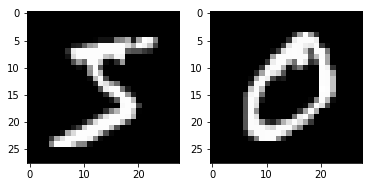

50000


In [3]:
print("Raw")
print(np.mean(all_raw_images))
print(np.var(all_raw_images))

print("Whitened")
print(np.mean(images))
print(np.var(images))


def show_images(images):
    n = len(images)
    fig, axarr = plt.subplots(1, n)

    for i in range(n):
        im = images[i]
        im = np.asarray(im)

        im = im.reshape([28,28])
        axarr[i].imshow(im, cmap='gray')

    plt.show()
    
show_images(images[:2])
print(len(images))

Whitened Test
-1.77187063208e-16
1.0


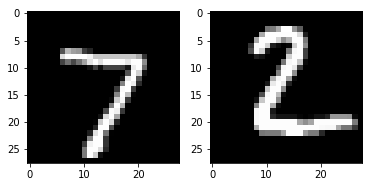

10000


In [4]:
print("Whitened Test")
print(np.mean(test_images))
print(np.var(test_images))

show_images(test_images[:2])
print(len(test_images))

In [5]:
import tensorflow as tf
print(tf.__version__)

1.1.0


In [6]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

['/gpu:0']


In [7]:
# b = tf.random_normal([20000])
# ary = b.eval()
# plt.hist(ary, 50)
# plt.show()
# print(ary.mean())
# print(ary.std())

In [8]:
# Test that we're using the GPU
shape = (1500, 1500)
from datetime import datetime
with tf.device('/gpu:0'):
    random_matrix = tf.random_uniform(shape=shape, minval=0, maxval=1)
    dot_operation = tf.matmul(random_matrix, tf.transpose(random_matrix))
    sum_operation = tf.reduce_sum(dot_operation)

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
    for i in range(200):
        result = session.run(sum_operation)
        print(result)

8.43311e+08
8.44051e+08
8.43281e+08
8.4482e+08
8.43929e+08
8.43071e+08
8.44321e+08
8.42013e+08
8.41889e+08
8.43841e+08
8.44286e+08
8.43767e+08
8.44126e+08
8.44304e+08
8.4424e+08
8.44471e+08
8.44111e+08
8.44314e+08
8.43657e+08
8.43532e+08
8.43901e+08
8.44104e+08
8.4389e+08
8.43493e+08
8.44318e+08
8.43069e+08
8.42836e+08
8.4438e+08
8.43335e+08
8.45654e+08
8.43995e+08
8.43751e+08
8.43938e+08
8.42984e+08
8.43615e+08
8.44177e+08
8.43717e+08
8.44172e+08
8.4423e+08
8.44487e+08
8.43551e+08
8.43815e+08
8.43867e+08
8.44922e+08
8.43814e+08
8.44042e+08
8.43832e+08
8.43592e+08
8.4387e+08
8.43574e+08
8.44387e+08
8.44931e+08
8.44287e+08
8.441e+08
8.44604e+08
8.43752e+08
8.44616e+08
8.4442e+08
8.44416e+08
8.43737e+08
8.44531e+08
8.4453e+08
8.43917e+08
8.43639e+08
8.44659e+08
8.42934e+08
8.44287e+08
8.43841e+08
8.44488e+08
8.44683e+08
8.44479e+08
8.44613e+08
8.44852e+08
8.4531e+08
8.43392e+08
8.42798e+08
8.44244e+08
8.44654e+08
8.43464e+08
8.44203e+08
8.44365e+08
8.45233e+08
8.43664e+08
8.44962e+08
8.4

In [61]:
def check_accuracy(test_ims, test_ys):
    
    total_correct = 0
    for i in range(len(test_ims) // batch_size):
        logits_out = sess.run(logits, feed_dict={
            x: test_ims[i*batch_size:(i+1)*batch_size],
            keep_prob: 1.0
        })

        y_pred = np.argmax(logits_out, 1)
        correct = (y_pred - test_ys[i*batch_size:(i+1)*batch_size]) == 0
        total_correct += correct

    acc = np.sum(total_correct) / len(test_ys)

    message = "%s correct out of %s => accuracy: %s" % ( np.sum(total_correct), len(test_ys), acc)
    return acc, message

In [64]:
# Set the seed for determinism
tf.reset_default_graph()
tf.set_random_seed(1)

# Build our models
input_size = 28*28
output_size = 10
batch_size = 50 # To use GPU correctly

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool_2x2(x):
    """Use this to halve the size after a conv"""
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def weight_var(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

def bias_var(shape):
    return tf.Variable(tf.constant(0.1, shape=shape))

with tf.device('/gpu:0'):
    x = tf.placeholder(tf.float32, shape=(None, input_size))
    y_train = tf.placeholder(tf.int32, shape=(batch_size))

    # Conv weights
    W_conv1 = weight_var([5, 5, 1, 32])
    b1 = bias_var([32])
                
    W_conv2 =  weight_var([5, 5, 32, 64])
    b2 = bias_var([64])
    
    # Conv layers
    x_image = tf.reshape(x, [-1, 28, 28, 1])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b1) # (28x28x32)
    h_pool1 = max_pool_2x2(h_conv1) # (14x14x32)
    
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b2) # (14x14x64)
    h_pool2 = max_pool_2x2(h_conv2) # (7x7x64)
    
    h_pool2_size = 7*7*64
    h_pool2_flat = tf.reshape(h_pool2, [-1, h_pool2_size])
    
    
    # FC weights
    W3 = weight_var([h_pool2_size, 1024])
    b3 = bias_var([1024])

    W4 = weight_var([1024, output_size])
    b4 = bias_var([output_size])
    
    # FC layers    
    h_fc = tf.nn.relu(tf.matmul(h_pool2_flat, W3) + b3)    

    keep_prob = tf.placeholder(tf.float32)
    h_fc_drop = tf.nn.dropout(h_fc, keep_prob)

    logits = tf.matmul(h_fc_drop, W4) + b4
    
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_train, logits=logits)
    loss = tf.reduce_mean(cross_entropy)
    
    # Optimizers
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    # global_step = tf.Variable(0, trainable=False, name="global_step")
    # train_op = optimizer.minimize(loss, global_step=global_step)
    train_op = optimizer.minimize(loss)

    
sess = tf.InteractiveSession()

In [65]:
report = {
    'loss': [],
    'val_acc': [],
}

def sample(images, labels, n=50):
    sample_indices = random.sample(range(len(images)), n)
    return images[sample_indices], labels[sample_indices]

n_epochs = 20

# Clear out the session
sess.run(tf.global_variables_initializer())
for i in range(n_epochs*1000+1):
    # Train with a minibatch

    train_ims, train_labels = sample(images, labels)
    _, l = sess.run([train_op, loss], feed_dict={
        x: train_ims,
        y_train: train_labels,
        keep_prob: 0.5,
    })

    if i % 50 == 0:
        report['loss'].append(l)
        acc, acc_msg = check_accuracy(*sample(val_images, val_labels, 1000))

        report['val_acc'].append(acc)
        
        
    if i % 200 == 0:
        print("\nIteration: %s loss: %s" % (i, l))
        print(acc_msg)


Iteration: 0 loss: 17.5211
149 correct out of 1000 => accuracy: 0.149

Iteration: 200 loss: 0.117368
975 correct out of 1000 => accuracy: 0.975

Iteration: 400 loss: 0.0510838
971 correct out of 1000 => accuracy: 0.971

Iteration: 600 loss: 0.00488311
982 correct out of 1000 => accuracy: 0.982

Iteration: 800 loss: 0.398493
984 correct out of 1000 => accuracy: 0.984

Iteration: 1000 loss: 0.00760647
982 correct out of 1000 => accuracy: 0.982

Iteration: 1200 loss: 0.0110459
990 correct out of 1000 => accuracy: 0.99

Iteration: 1400 loss: 0.0128171
993 correct out of 1000 => accuracy: 0.993

Iteration: 1600 loss: 0.187884
984 correct out of 1000 => accuracy: 0.984

Iteration: 1800 loss: 0.0521996
989 correct out of 1000 => accuracy: 0.989

Iteration: 2000 loss: 0.00480486
982 correct out of 1000 => accuracy: 0.982

Iteration: 2200 loss: 0.0727346
986 correct out of 1000 => accuracy: 0.986

Iteration: 2400 loss: 0.000382183
986 correct out of 1000 => accuracy: 0.986

Iteration: 2600 los

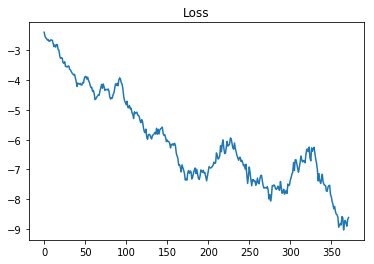

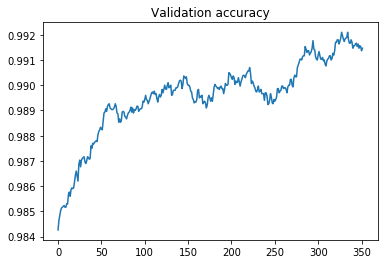

Final validation accuracy: 99.3%
Final test accuracy: 99.2%


In [78]:
def smooth(vals):
    window = 30    
    return np.convolve(vals, np.ones(window)/window, mode='valid')

plt.plot(smooth(np.log(report['loss'])))
plt.title("Loss")
plt.show()

plt.title("Validation accuracy")
ys = smooth(report['val_acc'][20:])
plt.plot(ys)
plt.show()

print("Final validation accuracy: %.1f%%" % (np.mean(report['val_acc'][-10:]) *100))

acc, _ = check_accuracy(test_images, test_labels)
print("Final test accuracy: %.1f%%" % (acc*100))

In [41]:
# Render misclassified data
test_ims = test_images
test_ys = test_labels

total_correct = 0
wrongs = []
for i in range(len(test_ims) // batch_size):
    logits_out = sess.run(logits, feed_dict={
        x: test_ims[i*batch_size:(i+1)*batch_size],
    })
    
    y_pred = np.argmax(logits_out, 1)
    incorrect_idxs, = np.where((y_pred - test_ys[i*batch_size:(i+1)*batch_size]) != 0)
    wrongs = np.concatenate([wrongs, incorrect_idxs + batch_size*i])
    total_correct += correct


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

[[-32.78782654 -18.80409431 -18.2261982   -5.76725149 -40.50658798
  -26.33099747 -53.90678024  55.30289841 -14.59173489  -4.13641834]]


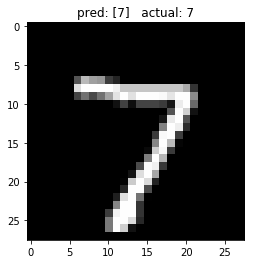

[[-13.54559994 -17.16925812  53.93415833 -29.38195992 -27.91591454
  -44.28226471 -16.67016602 -26.58813095 -14.89319992  -8.48960018]]


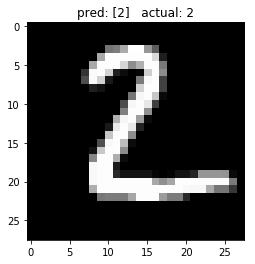

[[-20.3236599   24.16963005  -6.77490425 -22.29978752   1.61597645
   -5.0883441  -15.00867176  -2.98487377  -6.94982719 -16.10570145]]


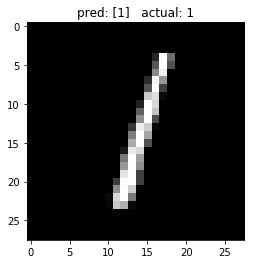

[[ 21.59737968 -13.03784657  -2.00087881 -10.19073868  -9.38484669
  -14.20948124  -1.81314921  -4.47589493  -3.66255569  -5.17272758]]


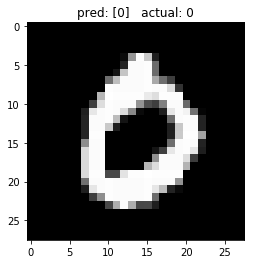

[[-18.64811516 -15.18683434 -12.01065445 -30.73213959  39.45056534
   -7.26129961 -16.51449585  -8.35106468  -7.0757637   -3.14340329]]


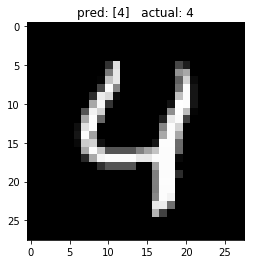

[[-14.98930359  23.53985596  -3.27886891 -24.13170052  -5.41571188
  -12.99356461 -14.7367754   -1.15397012  -4.36472368 -16.15122986]]


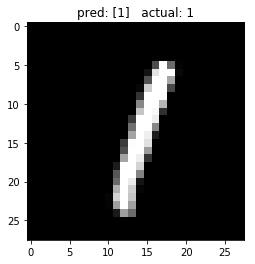

[[-28.1022625   -7.65487051 -14.64680672 -29.96127129  33.30144119
   -9.99459171 -16.89731407  -8.81637669  -6.77366638   3.7880559 ]]


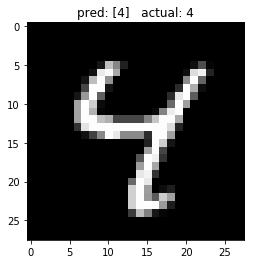

[[-25.73719215 -26.23814011  -4.71243763  -3.40092826  -8.29484844
  -12.13324642 -37.54005051 -12.50952053   0.38570499  32.05788803]]


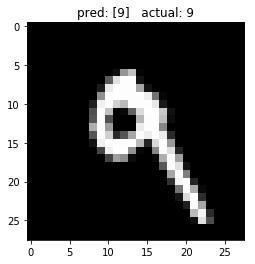

[[-23.07257652 -26.65577888 -24.94301796  -8.19094753 -18.87822151
   19.42292023  12.10006142 -25.99599266  19.07502937  -6.53101015]]


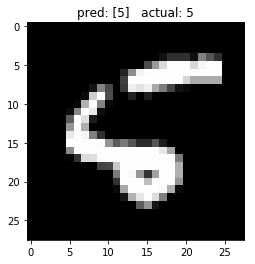

[[-23.25803566 -25.76489258 -25.15906334 -13.6071167   -6.13436699
  -13.39045143 -38.67422104  -5.22170019   7.21969748  26.48670387]]


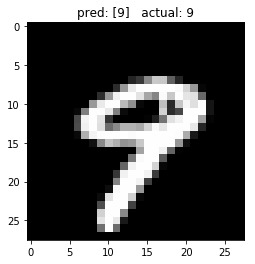

[[ 31.10396004 -22.46651649  -0.66608053 -14.39198112 -14.286623
  -24.88856888  -6.10871077 -14.28614807  -8.14871216  -4.56668091]]


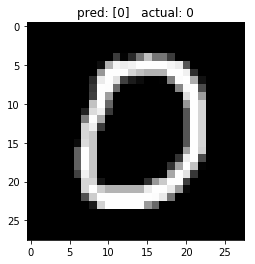

[[-13.65258121 -26.27600288 -29.43537903 -11.55226707 -24.35696983
   -1.38305128  72.01792145 -38.05057526  -7.7516098  -34.52480316]]


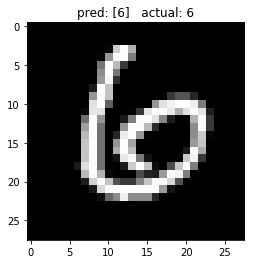

[[-24.34666252 -21.17610359 -19.47372627 -11.99206734   6.03663445
  -10.8046999  -32.57931137  -3.52775693  -1.84017932  27.74722099]]


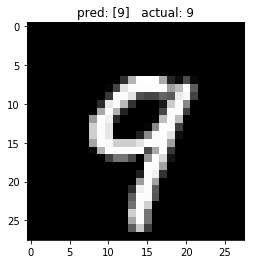

[[ 35.82928085 -25.81583405 -12.03346729 -19.15872765 -10.86879158
  -18.91722679  -7.77424145  -8.74085236  -6.51173115   0.68038112]]


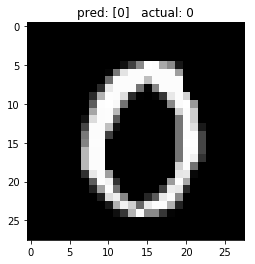

[[ -8.3010931   25.40488243 -12.3182354  -11.20138073 -10.1204958
  -12.77112865 -16.44943237 -10.32546902  -4.24643326 -11.14446926]]


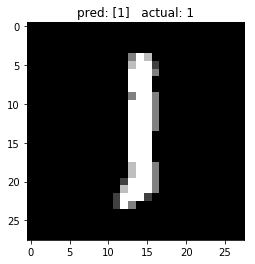

[[-15.26546383 -15.45539284 -26.63066292   5.01437616 -22.75240517
   33.80589294 -17.81056786 -18.22239876  -8.31865788 -11.28750992]]


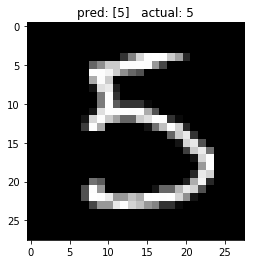

[[-26.32157707 -24.63162994 -20.28808784 -16.21765327   3.12728024
   -8.9289484  -37.59943771  -0.07951994   2.46689367  26.03454399]]


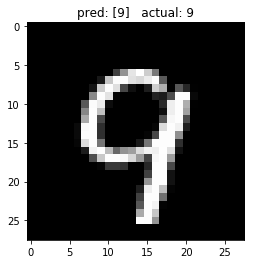

[[-29.07374382 -20.34879303 -15.76550674  -2.64386439 -36.63772583
  -24.40771675 -55.12258911  46.45476151 -12.93244457  -3.29365396]]


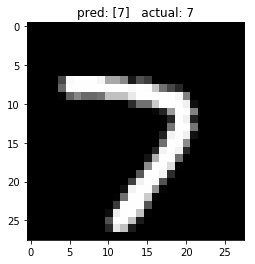

[[-10.30840492 -10.60939789  -4.12801027  11.60561562 -16.32674217
    2.93187809 -15.12438679 -11.07592773   1.87662196  -4.1531167 ]]


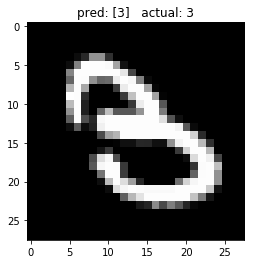

[[-24.93544197 -12.22420216 -14.64864159 -24.20717812  34.88479614
   -6.53759146 -17.40183258  -4.43736887  -4.85829401  -5.9443326 ]]


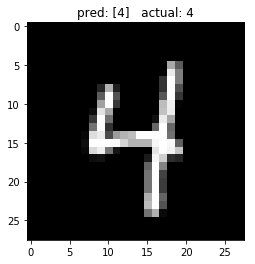

[[-19.7646656  -14.15723515 -22.46092415  -9.33285904  -1.86748087
   -7.80055761 -33.71925354   1.20023263  -5.86400032  27.90019798]]


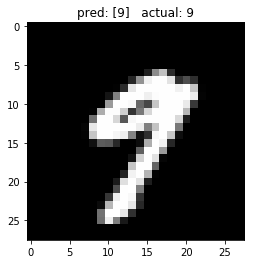

[[-10.35536861 -29.71182632  -4.16120863 -22.30436516 -21.74266624
   -3.11999965  45.54218674 -35.40077591  -5.63846684 -12.54431725]]


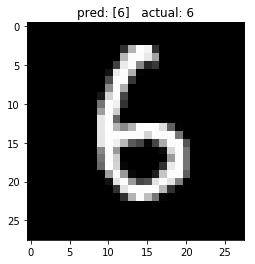

[[-15.77388287 -23.48588181 -24.72905731 -20.05654144  -3.6966083
   -5.08716106  54.50822067 -24.78641129 -10.75055218 -20.68803978]]


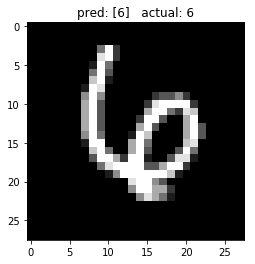

[[-23.56301689 -31.85198975 -24.99342537  -5.10538197 -22.72706032
   32.51259995  -0.08607227 -24.39638901  -1.40778315   0.77213204]]


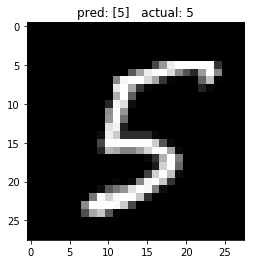

[[-22.99231529 -10.22743416 -14.21114159 -25.76318169  29.30783463
   -8.3177824  -15.07558155  -8.69551659  -4.04298353   3.15811658]]


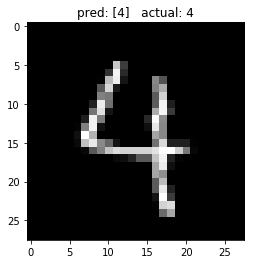

[[ 32.68068695 -22.67235947  -3.74832344 -25.1832695  -12.12226391
  -20.64427185  -0.30639964 -13.20567608 -13.28522301  -9.13564014]]


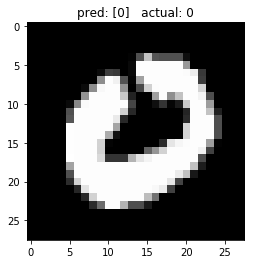

[[-28.17728996 -21.98497772 -10.68580914  -8.14826012 -31.91641808
  -21.53030014 -55.64770126  41.08857346 -17.13802719   4.37041998]]


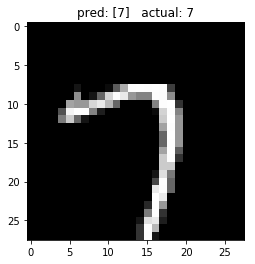

[[-28.35203743 -12.7647171  -14.33722591 -36.40973663  49.11244583
   -7.95881414 -17.93210602 -11.50580597  -9.73406792  -4.67152071]]


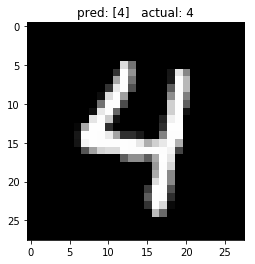

[[ 26.23665237 -21.59592438  -3.70375443 -10.87928104  -5.89570427
  -18.32164383 -12.474123    -9.85896492  -0.30079687  -2.84960246]]


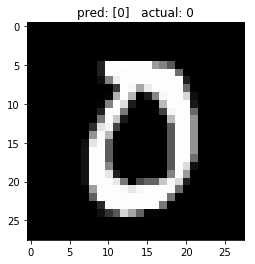

[[-12.81031036  27.18020058 -12.10038853 -15.28940296  -7.09506512
  -13.96964169 -22.7442627   -8.90157032  -5.13340807 -10.11557484]]


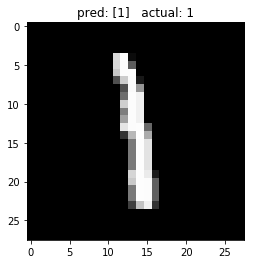

[[-35.81913376 -13.8780899  -20.66520119  50.05925369 -33.60273361
   -3.327492   -30.85486984 -19.03274918 -13.75409889  -6.51348925]]


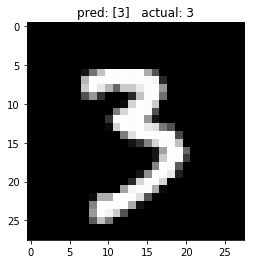

[[-11.71884823  22.93699074 -16.16980171 -26.98692894   0.88197577
  -15.14202213 -29.08901405  -7.16946268  -7.18656826  -7.3235755 ]]


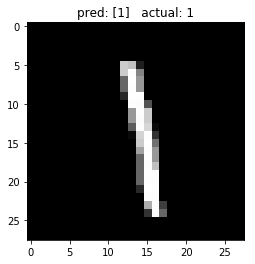

[[-29.56318092  -6.0685854  -18.03209877  38.11978149 -24.93393517
    0.46668899 -27.44187164 -15.5713892   -9.68844318  -2.94807696]]


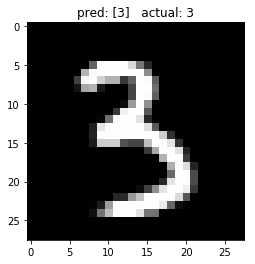

[[  4.47469044  -4.4319706   -1.74409592 -37.929039    36.45029831
   -9.83988857 -10.44020176 -17.63128281 -13.70519161 -23.08423996]]


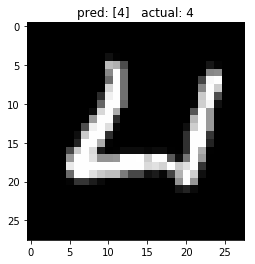

[[-25.15558052 -12.94656181 -10.72406673  -2.30452037 -32.55449677
  -23.7690506  -37.48763657  35.58269119  -9.78604698  -7.2744689 ]]


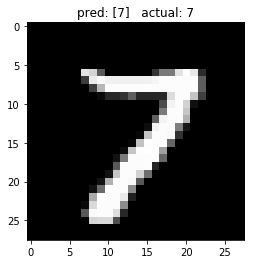

[[ -5.36467934  -8.39459896  37.39702606 -12.2171402  -24.91974258
  -29.29938126 -17.05960464 -10.69931507 -12.20503616  -9.81087589]]


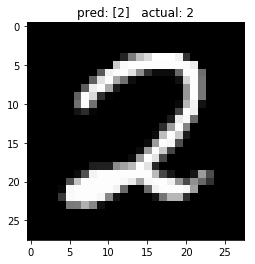

[[-34.15729523 -11.3056469   10.38386536   1.54720736 -40.65914536
  -35.07672119 -37.91548538  40.01004028 -14.14979744 -18.88538361]]


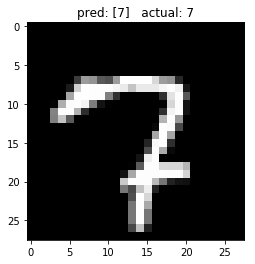

[[ -7.95338154  24.71154785 -13.54056358 -24.37435532  -4.36955929
  -15.06141186 -21.22537994  -5.54063892  -3.76998854  -5.7558465 ]]


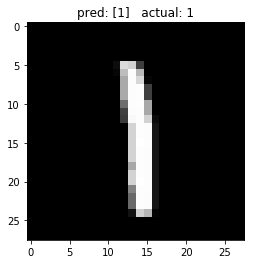

[[ -8.61866188  -2.22473955  33.64357758 -13.05737305 -22.17956161
  -36.79737473 -14.59619141 -11.15324497  -7.47259474 -10.42088223]]


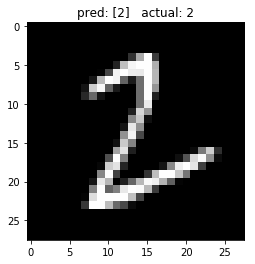

[[ -7.87778044  22.56249428  -9.81853294 -19.38674736  -5.14084578
  -13.23937511 -10.11832047  -7.28225374  -2.85274649  -6.30334759]]


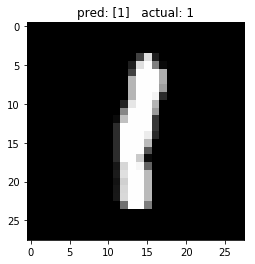

[[ -7.76665592  14.73929787  -8.6082058  -18.8416729   -4.57425308
  -10.05363846 -17.00082016  -7.71589375   2.69159412 -13.77589607]]


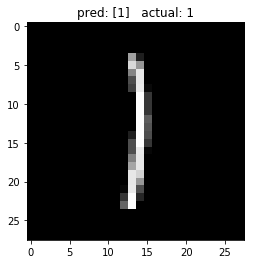

[[-26.86277199  -1.24751711   1.11818111  -7.2886548  -23.2416935
  -26.65226746 -37.15107346  33.9436264  -12.06216526  -9.50298882]]


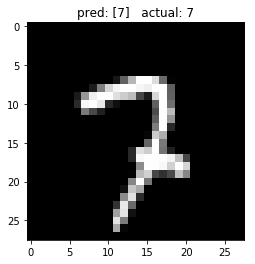

[[-29.54813194  -6.37943029 -23.47795486 -25.57059288  32.49039459
  -10.35500145 -14.03944206  -4.00709867  -8.19425583   5.91549301]]


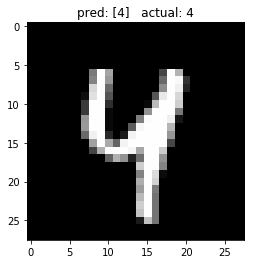

[[-31.12762451  -0.42521244  37.81811523 -11.50246429  -3.71632862
  -28.71170425   2.09852934 -23.98545265 -12.29272842 -34.2508049 ]]


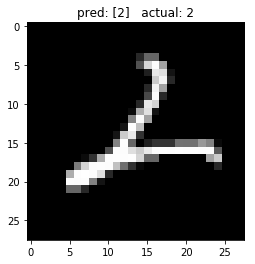

[[-20.11124039  -6.87045336  -7.70839167  24.13020515 -20.5880146
    0.0630113  -12.64547825 -14.72843361  -4.78223753  -7.17102146]]


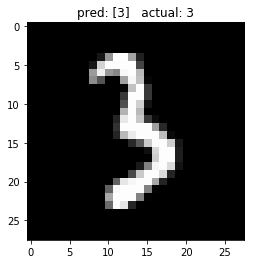

[[-17.13186073 -20.84334564 -21.64391899  -3.48920655 -17.02033997
   22.10170364  -4.86701918 -17.65459442   5.43664837  -3.41383338]]


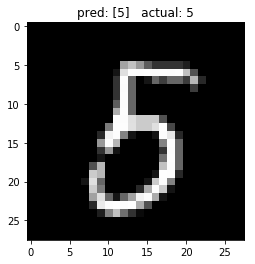

[[-12.69295597  26.84166336  -8.37345695 -20.18605042   1.42070782
  -23.77061653 -29.74855804 -11.87713432  -6.68473434  -9.51264668]]


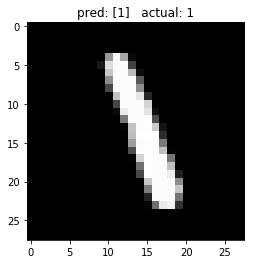

[[-24.13994789 -15.14652634  58.89334869 -10.6202383  -33.80753708
  -27.07404327 -16.39930344 -20.69046211   4.52182484 -27.66279411]]


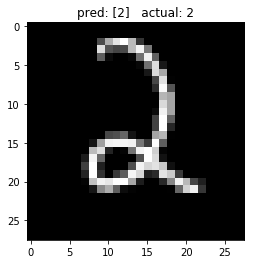

[[-20.05458641  -6.75337219 -16.05619621 -12.50659657  20.25045967
   -5.50318098 -17.29613495  -4.94183207  -2.14027929   7.18632412]]


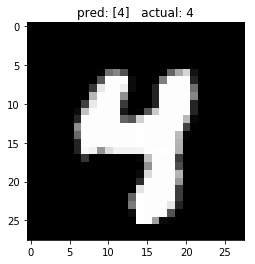

[[-26.86427116 -16.51991081 -20.54847145 -31.48046494  43.38489151
  -15.31461716 -22.49877167 -13.59072208  -8.91609955   2.04633641]]


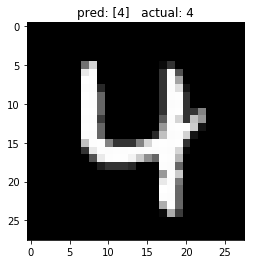

[[-10.81729603 -26.55825806   0.75770992 -10.3975029  -13.46095943
   -0.97396195  35.07597733 -27.22810364  -5.18611717 -12.3102541 ]]


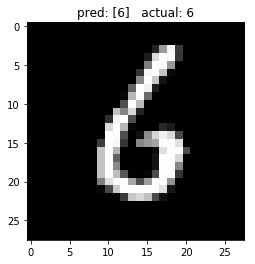

[[-16.78043175  -6.51267338 -12.47137737  33.93452072 -22.11738014
   -7.2438736  -22.31733131 -11.23638535  -4.13132763  -5.66089916]]


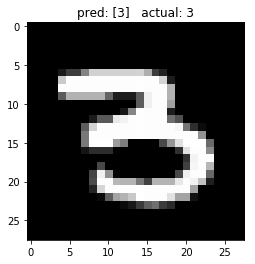

[[-28.03903961 -36.44549179 -32.68344116  -1.89409208 -21.5901413
   42.85181046 -18.23590088 -27.78079987   1.49460101  -2.25924897]]


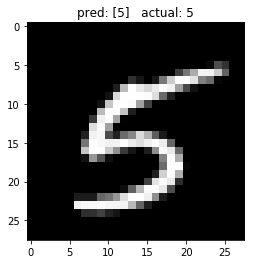

[[-24.6068325  -21.76996231 -34.25697327  -1.65178728 -12.64359188
   39.11587524 -18.95882607 -18.40023041  -4.66212177  -2.18061328]]


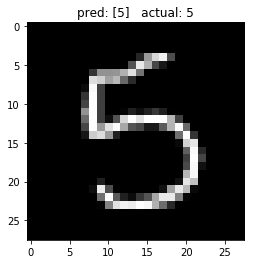

[[-21.54050255 -27.09510994 -49.18658066  -9.20402813 -15.91466331
    7.0272603   74.97185516 -40.15242004  -5.17422676 -29.51096916]]


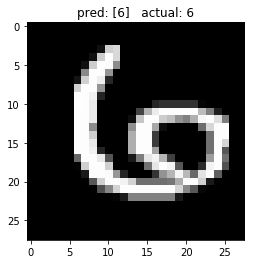

[[ 26.68484306 -14.22516537  -4.09134531 -16.97998619  -8.30881596
  -18.69911957  -2.05228901 -10.28784275   2.19421601  -1.24443448]]


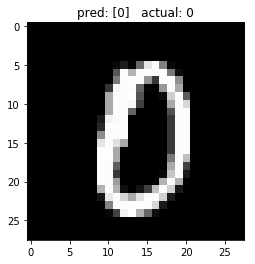

[[-27.65339851 -14.22723961 -16.56126022 -36.49616241  50.67781448
  -13.20406914 -15.48892212 -10.43669605 -12.03993797 -11.80467701]]


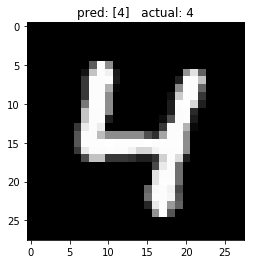

[[-12.59613895  17.83176041   1.02994168 -22.19500732  -4.17190838
  -15.15887833 -10.37941647  -0.16388924  -2.63106775 -12.68122578]]


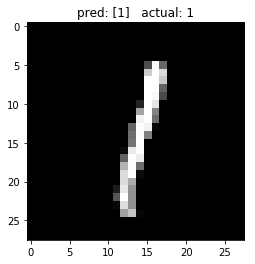

[[-23.64229774 -34.82870483 -23.19210815 -14.49184036   3.31986809
   -6.37427521 -45.00468826  -5.51413155  -2.26832819  35.50911331]]


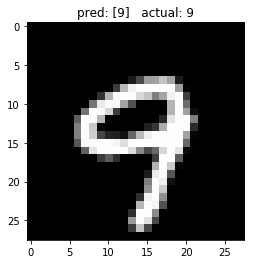

[[-33.02301025 -24.39721298 -36.79609299 -15.56711006  -9.48251152
   39.90399933 -30.55709648  -7.37310123  -0.8620826    0.36538547]]


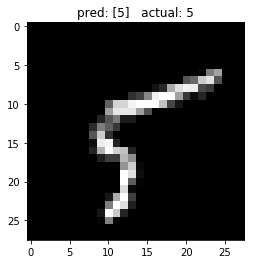

[[-32.89266968 -16.27450371 -14.81594086   3.11267138 -35.44070435
  -18.45110321 -54.44916534  44.23747253 -15.74503517  -5.87771177]]


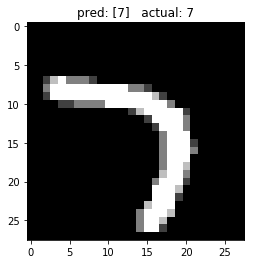

[[-16.5774498  -33.28159332   6.99254751 -12.81287575 -33.73297501
  -28.18237877 -10.37533855 -32.62769318  44.18239594  -9.15603065]]


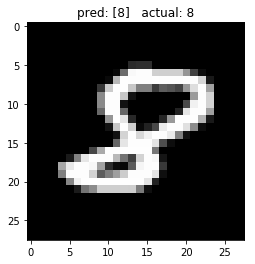

[[-16.95125008 -18.43736267 -16.42079544 -10.7835083   -6.58434439
   -3.36506629 -15.57476902   3.32250524   5.79127216  10.31374645]]


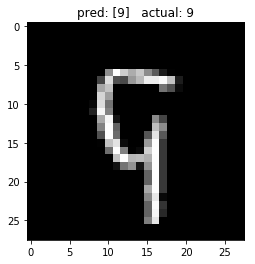

[[-16.37063599 -11.09736252  -1.62735534  25.35164452 -21.70838165
  -10.90892982 -22.69782448 -12.41138363   4.28561687  -8.36620712]]


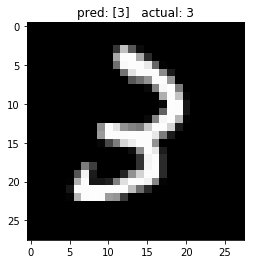

[[-39.59386444 -15.20303154 -16.27601051  -8.55907154 -10.58283329
  -21.85373306 -40.24148941  30.63442993 -10.66682434  -3.8642602 ]]


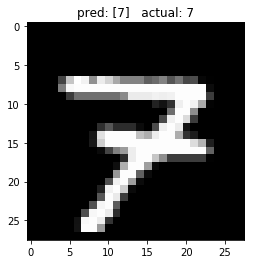

[[-12.51702404  -1.61643767  -7.99143934 -13.147686    17.91586685
   -6.54444933 -15.2086935   -8.7100172   -4.21014404   0.29255307]]


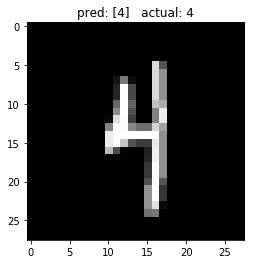

[[-10.56488705 -19.73135185 -18.65841484 -12.77168751  -7.72298956
   -3.96667123  47.22798538 -22.86662102  -4.49493027 -21.48614883]]


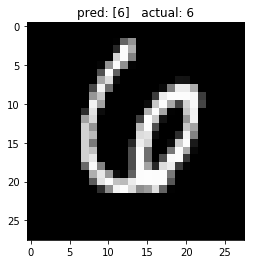

[[-18.62725639 -13.60360622 -13.40166664 -30.61987114  33.31665421
   -4.03250265 -20.39616966  -9.90032291  -3.68158889   6.30690718]]


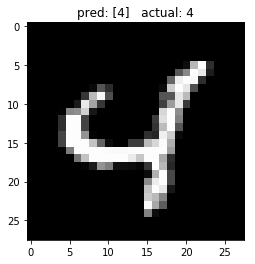

[[-29.59370232 -11.02540016 -11.8994112   37.76222229 -28.49555969
    0.38152421 -28.66123199 -12.3202734   -1.60340106  -1.16267622]]


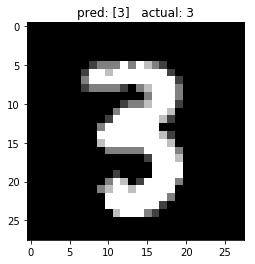

[[ 44.77054596 -25.9828434  -16.61668968 -13.08212566 -31.39883614
  -20.53620338 -11.10369015 -20.12506104 -13.40062904  -0.82680142]]


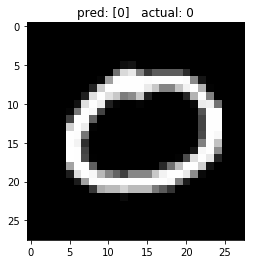

[[-36.33480835 -19.95538712 -17.81921768   5.57984161 -38.58829117
  -25.12221336 -63.35830307  50.15903091 -14.23847103  -5.81994009]]


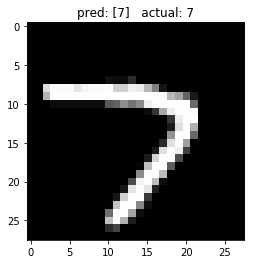

[[ 41.24747467 -24.6268158   -8.3170166  -23.27121162 -13.47170353
  -24.7034874   -4.12000608 -16.0381012  -10.81445885  -5.56001997]]


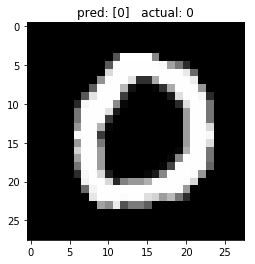

[[ -3.74013448 -11.12007523  39.17323303  -8.27571487 -23.81648064
  -28.58621979 -25.37576294  -3.14870191 -15.52579498 -18.71164322]]


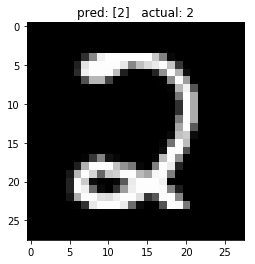

[[-13.05457306 -11.69057274 -19.81328201 -17.93015289  -8.03494453
  -15.55640697 -27.63636017   0.74852455   4.11957979  26.35502243]]


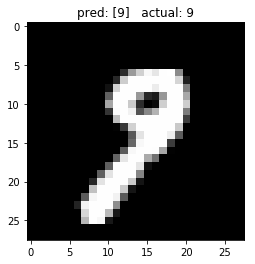

[[ -6.6549058   20.9512291   -8.05662346 -19.55917931  -4.17618275
  -15.73132801 -14.93768406  -3.99630427   1.8033973   -6.92267084]]


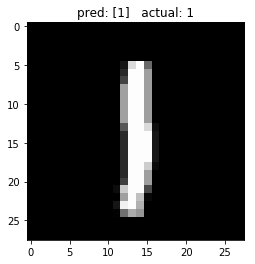

[[-32.52220535  -4.62963295  -8.0240078   -2.75980878 -13.02767754
  -28.56624985 -45.37530899  37.35783005 -14.5487566  -10.21168804]]


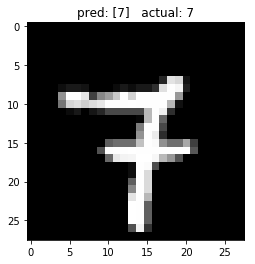

[[-24.12617874 -10.96037674 -13.15935421  35.29923248 -21.6533947
   -1.7444824  -27.28939629 -19.54979706  -7.50362301  -0.17338526]]


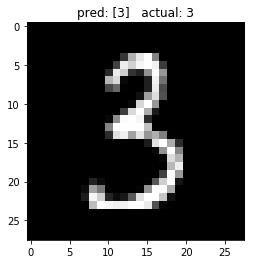

[[ -6.32152462  -4.64946795  40.52031708  -7.99403954 -31.18419266
  -34.76879501 -19.54249573   2.99931741 -19.21664238  -9.3038044 ]]


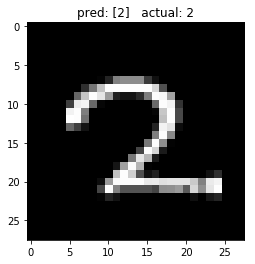

[[-15.99114704  -8.10795116 -10.63887405 -15.53382683  -1.55361259
  -13.30866718 -17.29989052  -4.31049728   1.25784945  20.9913826 ]]


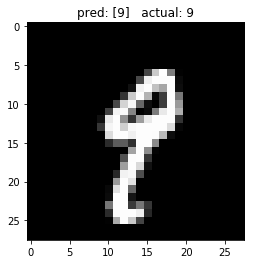

[[-19.88697624  -8.63574791 -11.11286068  -5.32035732 -31.51901436
  -24.42042542 -47.20393753  25.15382004  -5.39374304  -3.98603511]]


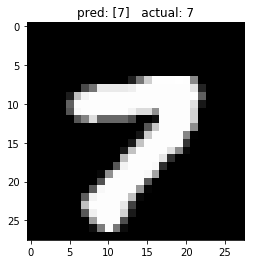

[[-12.62724018 -10.6368103  -14.02588463  -5.7230711  -18.01602745
  -13.32734585 -26.82533264  20.01200294  -3.09685135   2.50947738]]


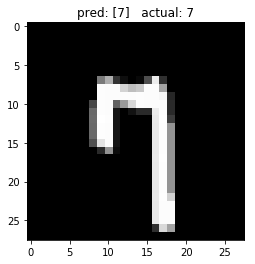

[[ -4.93945885 -27.91524506  -4.45018911 -14.88886356 -20.70226097
   -3.40908217  41.57188034 -33.31222916  -7.0505867  -13.36731815]]


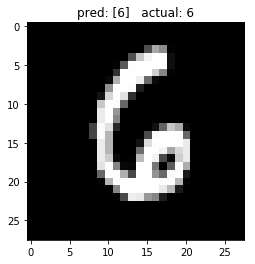

[[-20.39368248 -14.79535484  55.20018768 -12.95087719 -32.70234299
  -38.03670883 -29.91864395  -3.81900835  -7.19059229 -13.87112617]]


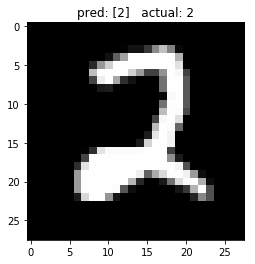

[[-22.7311573  -11.64484787  -9.93083382  -1.75620961 -33.68061829
  -25.04409409 -39.01993942  43.2203064   -8.79686451 -11.02179623]]


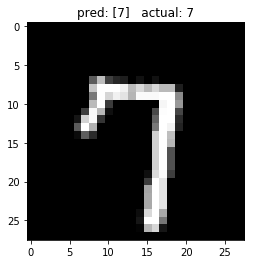

[[-18.64402771 -15.55295467  -4.7049408   -6.82644701  -6.97714615
  -11.03376484  -0.1913169  -18.1168766   28.91493416  -2.21714664]]


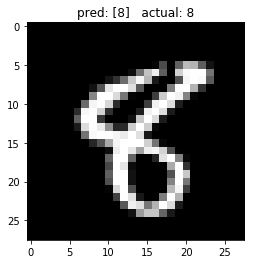

[[-24.4544239   -2.31607175 -20.97462654 -23.70503426  30.64148521
   -9.98451138 -14.7295866   -7.79861593  -3.40098953  -4.65084887]]


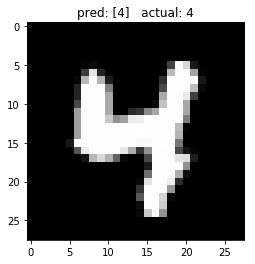

[[-25.2701683   -8.88971519 -12.21450901  -6.59845829 -29.83400345
  -21.65825081 -41.78430557  37.63677979  -7.34233427  -0.92367268]]


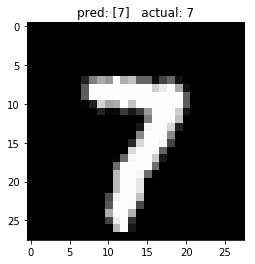

[[-22.60765648  -5.6241169  -10.0000124   32.11585236 -17.82236671
   -5.1449852  -24.92062759 -12.24920845  -6.60077667 -13.48669529]]


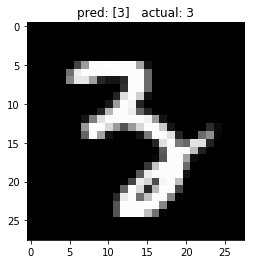

[[-12.22656536 -32.15594101 -20.20652199 -20.90427399 -16.81642723
  -17.0054245   78.66830444 -43.18464279 -16.56236839 -31.10536385]]


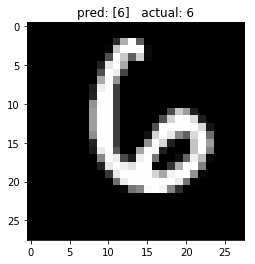

[[-12.90700054  12.32232761   1.29271817 -11.16949081  -3.43385148
   -8.99180031  -9.03625202  -2.37666869  -5.53705692 -16.39829063]]


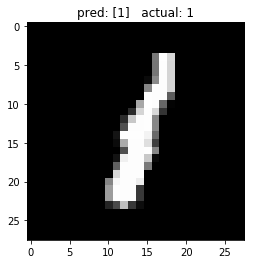

[[-26.67778206 -16.57327271  -5.63219023  45.58787537 -30.90952873
  -13.7241888  -34.25257874 -19.15323257  -6.89626503  -5.91083288]]


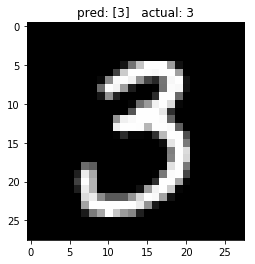

[[-14.67846203 -26.87345123  -4.03465176 -21.10508919 -10.38306808
   -5.54821205  52.6141243  -40.29590988 -14.2935791  -18.02283669]]


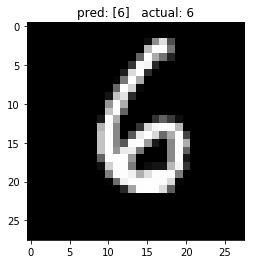

[[-16.79917336 -11.05960655 -14.12121105 -13.65031052  10.52745533
   -3.48289633 -16.84794044  -8.44037724  -2.11915827  14.41125965]]


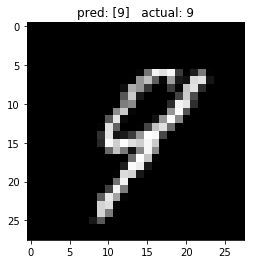

[[-22.60844612  -9.54339218 -15.44489288  32.76319885 -24.9854641
   -3.43519163 -30.87546158 -13.62801933  -6.50508595   5.781075  ]]


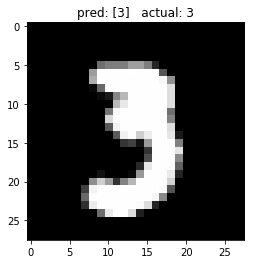

[[-10.69284725  23.94698334  -6.87249041 -22.59151459  -2.00272894
  -20.86553383 -17.25215912 -11.33913803  -2.3716011   -3.65864897]]


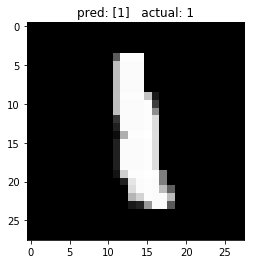

[[-13.5347662   -5.33305073  -9.3005476  -18.14945793  13.60325336
   -7.49859524  -5.6134696   -4.828372     3.94999146   8.22482204]]


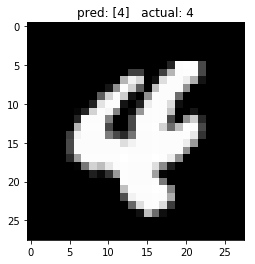

[[-13.7170496   17.22623062 -12.52558136 -15.82361794   2.8866396
  -15.41233253 -35.32563782  -6.35549212 -13.46704483   0.30441296]]


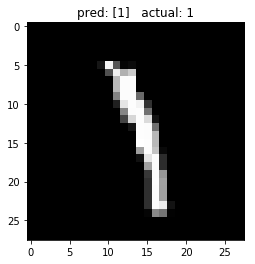

[[-28.02901077  -2.00635552  -8.39536381 -24.91054344  -4.83258057
  -30.95718765 -28.90603447  31.95891571  -8.61767769 -14.59844303]]


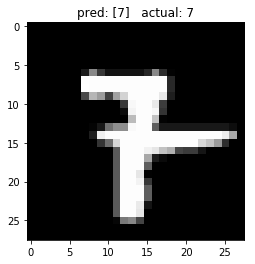

[[ -7.20112658 -35.18728256  -4.1070652  -24.84743309 -20.30375099
   -5.02545595  43.12989426 -42.64041901   0.54410493  -5.89324045]]


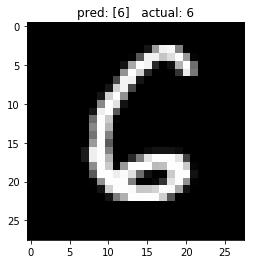

[[-28.99882507 -33.27540207 -24.93062973 -12.85223579  -5.23619175
  -11.63800335 -44.24435806  -1.57957733  -2.57517815  38.34066772]]


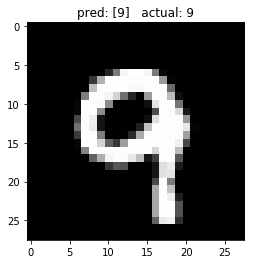

In [59]:
for idx in range(100):
# for idx in wrongs[10:20]:
    im = test_ims[int(idx)]
    logits_out = sess.run(logits, feed_dict={
        x: [im]
    })
    print(logits_out)

    im = im.reshape([28, 28])
    plt.imshow(im, cmap='gray')

    plt.title("pred: %s   actual: %s"  % (np.argmax(logits_out, 1), test_labels[int(idx)]))
    plt.show()
    
#     show_images([im, im])
    
